In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.9.7.29-1+cuda12.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Need to get 885 MB of archives.
After this operation, 56.3 kB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8-dev 8.9.7.29-1+cuda12.2 [440 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8 8.9.7.29-1+cuda12.2 [444 MB]
Fetched 885 MB in 31s (28.3 MB/s)
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../libcudnn8-dev_8.9.7.29-1+cuda12.2_amd64.deb ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
Unpacking libcudnn8-dev (8

In [ ]:
# NOTE (05/11/2022) - The default URL for downloading the dataset via TFDS is currently invalid. This piece of code
# will patch that URL with the correct one. Please run this before importing the packages. If it fails, kindly report
# in our Discourse community. Thank you!

DATASET_PATH = '/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py'
!sed -i 's/3367a/5340/g' {DATASET_PATH}

sed: can't read /usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py: No such file or directory


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [ ]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incomplete07BXXE/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
def preprocess(image,label):
    # Extract image and species label
    # Adjust if the key is different
    label = tf.one_hot(label, depth=2)


    return image, label

# Apply the preprocessing function to your dataset
train_data = train_data.map(preprocess)
validation_data = validation_data.map(preprocess)
test_data = test_data.map(preprocess)


In [ ]:
def augment_images(image, label):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)
augmented_validation_data = validation_data.map(augment_images)
validation_batches = augmented_validation_data.batch(32)

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

new_input = Input(shape=(300, 300, 3))
# Load InceptionV3 pre-trained model without the top layer (include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3),input_tensor=new_input)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of InceptionV3
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

base_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [ ]:
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_batches, epochs=10)  # Adjusting epochs based on pre-trained model characteristics


Epoch 1/10
582/582 [==============================] - 92s 134ms/step - loss: 0.0417 - accuracy: 0.9872
Epoch 2/10
582/582 [==============================] - 78s 131ms/step - loss: 0.0189 - accuracy: 0.9948
Epoch 3/10
582/582 [==============================] - 78s 131ms/step - loss: 0.0178 - accuracy: 0.9941
Epoch 4/10
582/582 [==============================] - 78s 131ms/step - loss: 0.0136 - accuracy: 0.9953
Epoch 5/10
582/582 [==============================] - 78s 131ms/step - loss: 0.0118 - accuracy: 0.9966
Epoch 6/10
582/582 [==============================] - 76s 127ms/step - loss: 0.0107 - accuracy: 0.9965
Epoch 7/10
582/582 [==============================] - 75s 126ms/step - loss: 0.0102 - accuracy: 0.9967
Epoch 8/10
582/582 [==============================] - 76s 127ms/step - loss: 0.0081 - accuracy: 0.9973
Epoch 9/10
582/582 [==============================] - 78s 131ms/step - loss: 0.0075 - accuracy: 0.9981
Epoch 10/10
582/582 [==============================] - 76s 126ms/step - l

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

x = GlobalAveragePooling2D()(base_model.output)
output = Dense(2, activation='softmax')(x)

# Create the new CAM model
cam_model = Model(inputs=new_input, outputs=[base_model.get_layer('mixed10').output, output])

current_weights, current_biases = cam_model.layers[-1].get_weights()

# Assign gap_weights to the weights part, keeping biases the same
cam_model.layers[-1].set_weights([gap_weights, current_biases])
#cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [ ]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction =  np.argmax(results[0])

  class_labels = ['Cat', 'Dog']
  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,np.argmax(results[0])]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/8, 300/8, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  predicted_class = class_labels[prediction]
  # visualize the results
  print(f'softmax output: {results}')
  print(f"prediction class: {predicted_class}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


In [ ]:
!wget -O cat1.jpg https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg
!wget -O cat2.jpg https://i.natgeofe.com/n/9135ca87-0115-4a22-8caf-d1bdef97a814/75552.jpg
!wget -O catanddog.jpg https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_square.jpg
!wget -O dog1.jpg https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg
!wget -O dog2.jpg https://www.hindustantimes.com/ht-img/img/2023/08/25/1600x900/international_dog_day_1692974397743_1692974414085.jpg

--2023-12-28 15:40:20--  https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg
Resolving www.alleycat.org (www.alleycat.org)... 141.193.213.20, 141.193.213.21
Connecting to www.alleycat.org (www.alleycat.org)|141.193.213.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107329 (105K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 104.81K  --.-KB/s    in 0.007s  

2023-12-28 15:40:20 (13.9 MB/s) - ‘cat1.jpg’ saved [107329/107329]

--2023-12-28 15:40:20--  https://i.natgeofe.com/n/9135ca87-0115-4a22-8caf-d1bdef97a814/75552.jpg
Resolving i.natgeofe.com (i.natgeofe.com)... 23.216.147.15, 23.216.147.40, 2600:1409:7800::17d7:b031, ...
Connecting to i.natgeofe.com (i.natgeofe.com)|23.216.147.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060932 (1.0M) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jpg            100%[===================>]   1.01M  --.-KB/s    in 0.04s   

2023-12-28 15:40:20 (25

1/1 [==============================] - 3s 3s/step
softmax output: [[9.9999809e-01 1.9424847e-06]]
prediction class: Cat


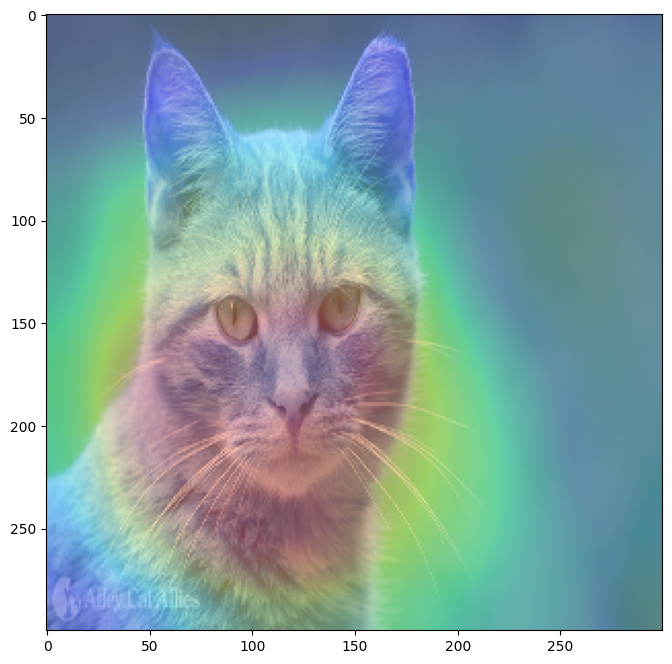

1/1 [==============================] - 0s 25ms/step
softmax output: [[9.9999452e-01 5.5030073e-06]]
prediction class: Cat


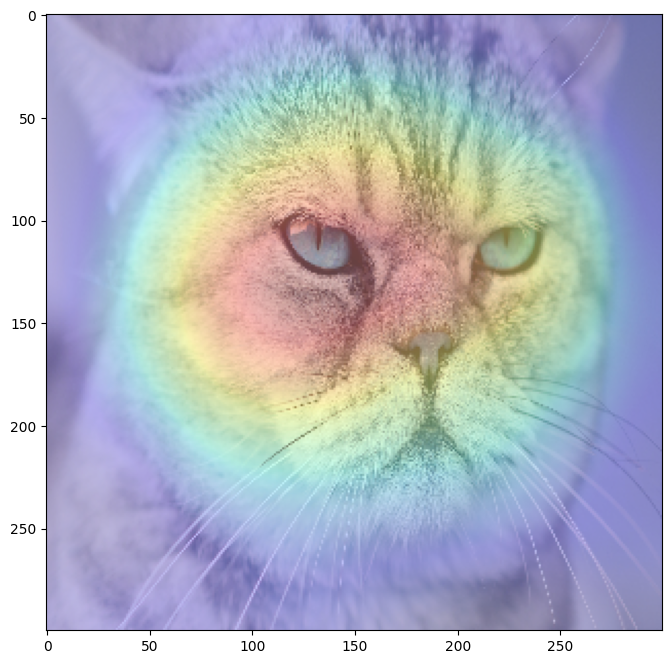

1/1 [==============================] - 0s 25ms/step
softmax output: [[1.0000000e+00 3.4853773e-09]]
prediction class: Cat


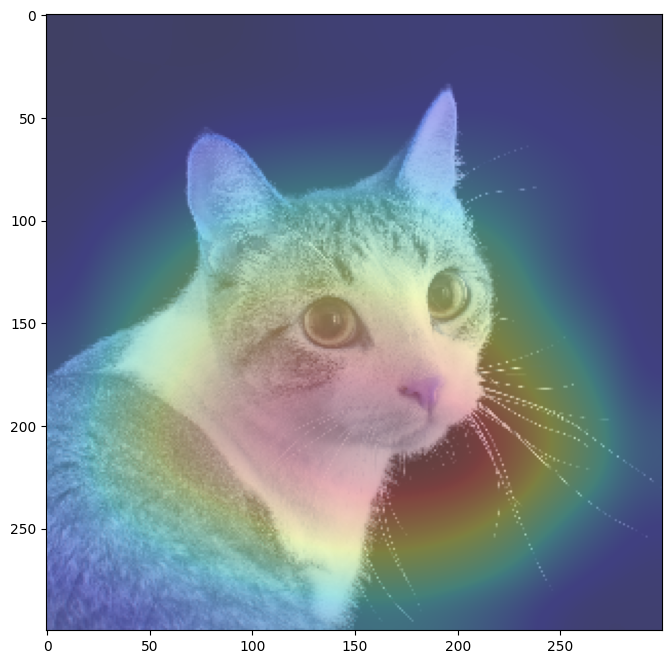

1/1 [==============================] - 0s 40ms/step
softmax output: [[2.8607119e-05 9.9997139e-01]]
prediction class: Dog


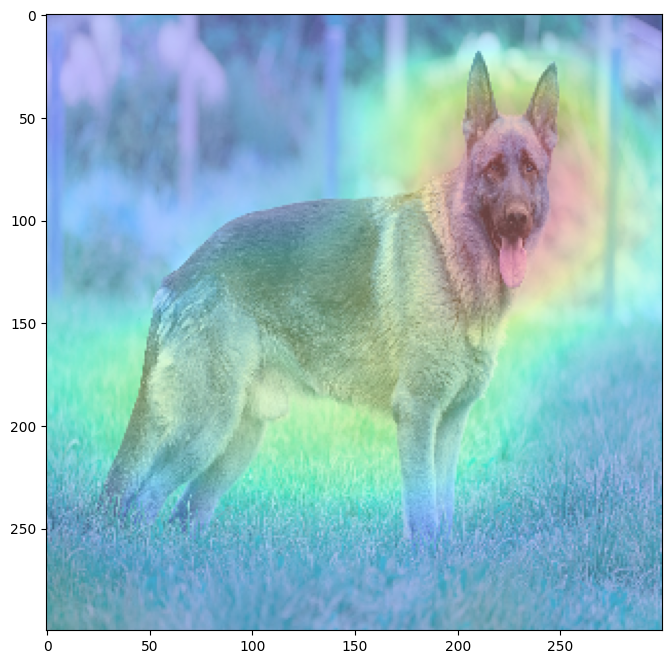

1/1 [==============================] - 0s 43ms/step
softmax output: [[1.8600341e-06 9.9999809e-01]]
prediction class: Dog


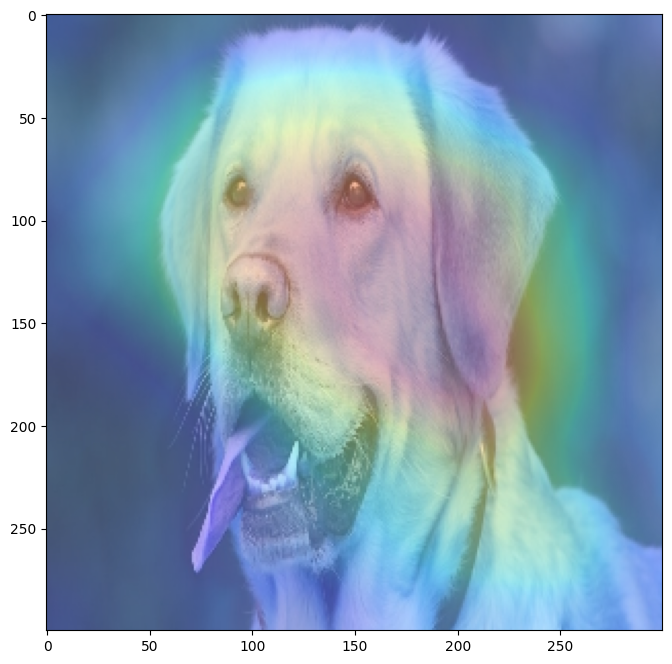

In [ ]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
1/1 [==============================] - 0s 25ms/step
softmax output: [[9.9999261e-01 7.3989495e-06]]
prediction class: Cat


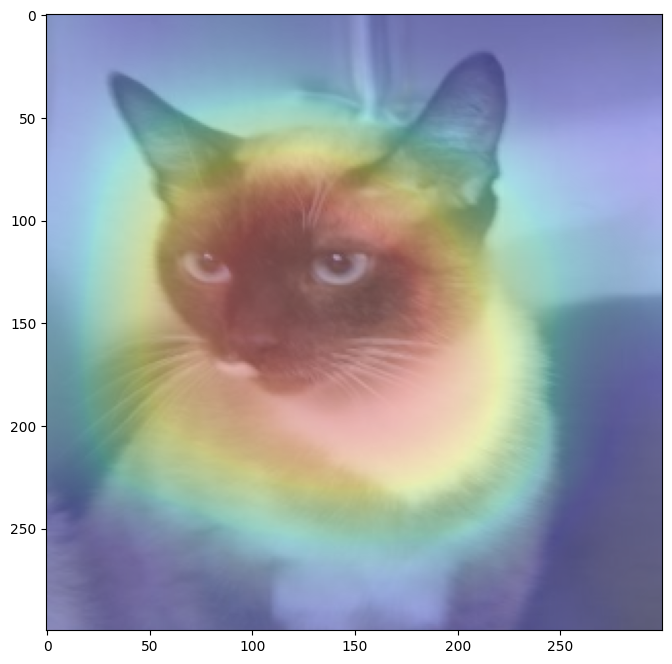

ground truth: dog
1/1 [==============================] - 0s 26ms/step
softmax output: [[0.00143979 0.99856025]]
prediction class: Dog


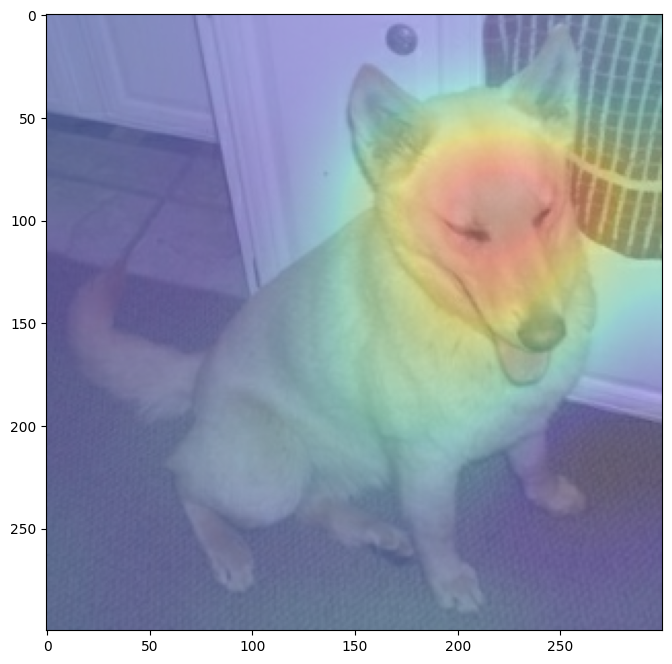

ground truth: dog
1/1 [==============================] - 0s 38ms/step
softmax output: [[2.9687293e-05 9.9997032e-01]]
prediction class: Dog


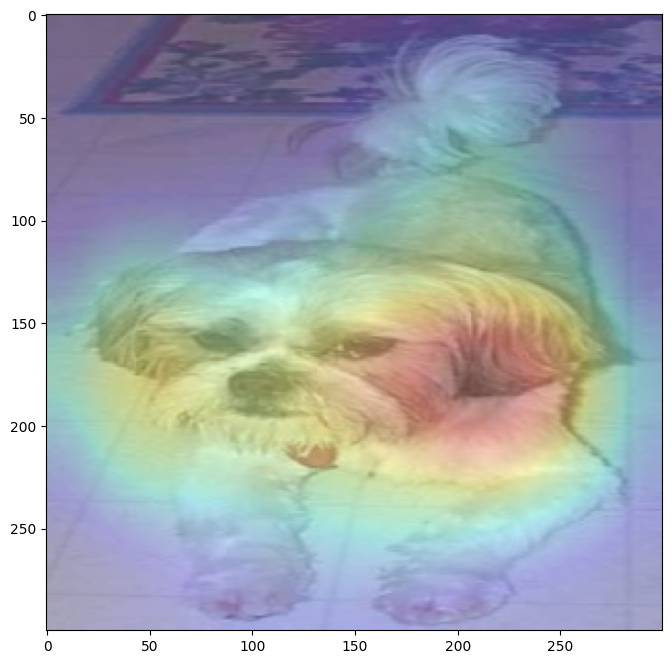

ground truth: cat
1/1 [==============================] - 0s 36ms/step
softmax output: [[9.9999988e-01 1.4588738e-07]]
prediction class: Cat


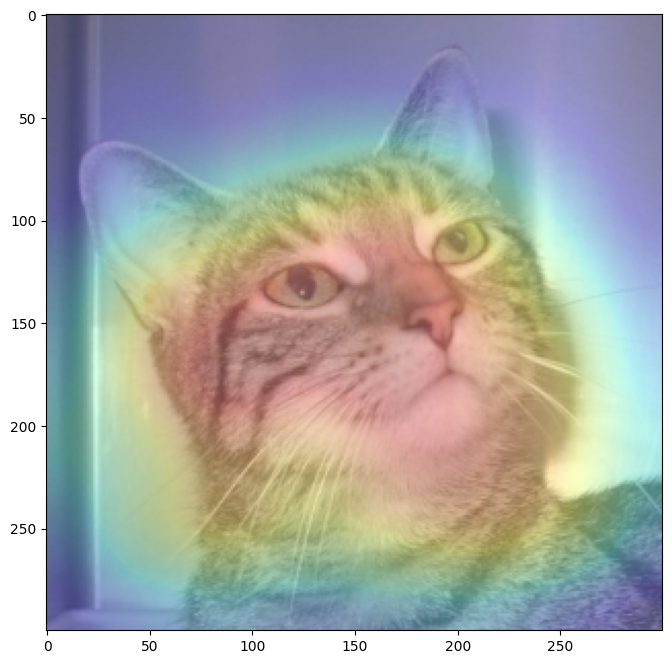

ground truth: cat
1/1 [==============================] - 0s 39ms/step
softmax output: [[9.9999976e-01 2.2350254e-07]]
prediction class: Cat


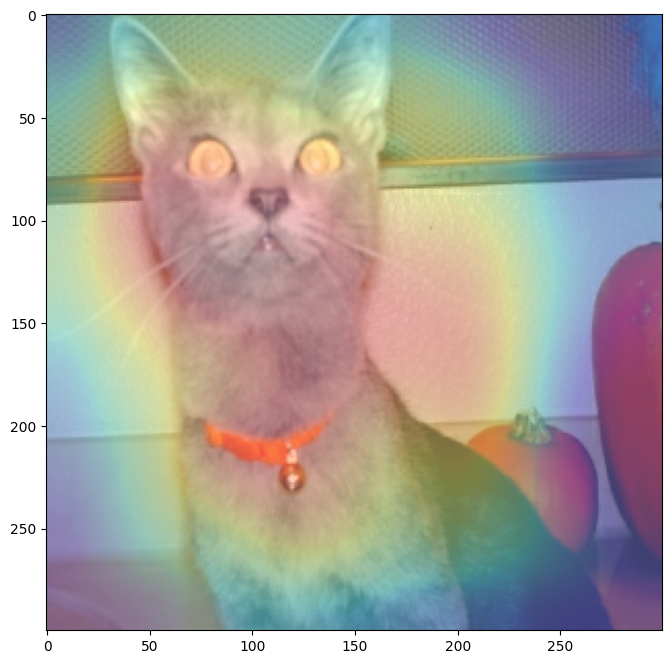

In [ ]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
    # Convert lbl tensor to numpy and use the first element for condition
    lbl_np = lbl.numpy()
    ground_truth = 'cat' if lbl_np[0][0] == 1 else 'dog'  # Adjust depending on how your labels are encoded

    print(f"ground truth: {ground_truth}")
    features, results = cam_model.predict(img)
    show_cam(img, features, results)